## Clustering Analysis of FEMA IHP Assistance in Florida
February, 2025

### 1. Introduction
#### 1.1 Background and objectives
The FEMA Individuals and Households Program (IHP) provides financial assistance and direct services to eligible individuals and households affected by a disaster, who have uninsured or underinsured expenses and serious needs.
There are two general types of financial assistance (for detail, refer to https://www.fema.gov/assistance/individual/housing)
- ***Housing Assistance (HA)***
    including rental assistance, lodging expense reimbursement, home repair or replacement, accessibility needs, 
temporary housing unit and hazard mitigation, etc.
- ***Other Needs Assistance (ONA)***
    including Serious Needs Assistance (SNA) and costs for displacement, childcare, clean and sanitize, funeral, Group Flood Insurance Policy, medical/dental and personal property, etc.

The objective of this analysis is to identify and explore the patterns in four variables of interest: 
> 1) IHP eligibility rate
> 2) HA eligibility rate
> 3) Housing Assistance (HA) amount
> 4) Other Needs Assistance (ONA) amount

Investigating the above variables help understand the IHP needs which will enable subsequent analysis that could lead to better preparation of FEMA's disaster response in areas such as fraud detection and cost planning. Given the sheer amount of data and diverse response due to incident type, socio-economic and demographic characteristics among the disasters, as well as the evolving FEMA IHP program policies, this study will focus on the analysis of severe storm and hurricane declarations in the state of Florida during 2024.

#### 1.2 Data
The FEMA **RegistrationIntakeIndividualsHouseholdPrograms** is a publicly accessible dataset from OpenFEMA API that contains aggregated, non-PII data from Housing Assistance Program reporting authority within FEMA's Recovery Directorate to share data on registrations and Individuals and Households Program (IHP) for declarations, segmented by city where registration is valid. The IHP is intended to help with critical expenses that cannot be covered in other ways. This dataset is raw, unedited data from FEMA's National Emergency Management Information System (NEMIS) and as such is subject to a small percentage of human error.

Data is downloaded from OpenFEMA API with a filter to extract a subset of declarations from Florida in year 2024, which include four major disaster declarations:  
> DR4794: severe storms and tornadoes<br>
> DR4806: Hurricane Debby<br>
> DR4828: Hurricane Helene<br>
> DR4834: Hurricane Milton<br>

Data source:

> Federal Emergency Management Agency (FEMA), *OpenFEMA Dataset: Registration Intake and Individuals Household Program (RI-IHP) - v2*, retrieved from https://www.fema.gov/openfema-data-page/registration-intake-and-individuals-household-program-ri-ihp-v2 on January 20, 2025. This product uses the FEMA OpenFEMA API, but is not endorsed by FEMA. The Federal Government or FEMA cannot vouch for the data or analyses derived from these data after the data have been retrieved from the Agency's website(s).

#### 1.3 Methodology
Since the problem is to identify unknown patterns in the IHP implementation results and no true labels are available, unsupervised machine learning algorithms seem to be a proper choice. Given the moderate number of observations and small dimension of the dataset (four features), **Kmeans** and **Agglomerative** clustering methods will be used and compared in this study. 

- The KMeans algorithm clusters data by separating samples into a predefined number of groups of equal variance by minimizing the within-cluster sum-of-squares. 

- The Agglomerative clustering algorithm is a type of hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together, forming nested clusters. 

To evaluate the clustering performance, two metrics: **within-cluster sum-of-squares (WCSS)** and **silhouette score** are calculated for both algorithms to help determine the final number of clusters to be generated. Although there is no strictly "right" or "wrong" answers to the clustering results in this problem, the superiority of either algorithm will be assessed for the interpreterbility of clusters for subsequant analysis. Although subsequant analysis is beyond the scope of this project, the evaluation procedure will be presented and briefly discussed here.

#### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind
import geopandas as gpd
import warnings

warnings.simplefilter(action = 'ignore',category = FutureWarning)
warnings.simplefilter(action = 'ignore',category = UserWarning)

### 2. Data wrangling and exploratory analysis
#### 2.1 Loading raw data, initial inspection

In [455]:
data = pd.read_csv('fema_riihp_raw.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8282 entries, 0 to 8281
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   disasterNumber                8282 non-null   int64  
 1   state                         8282 non-null   object 
 2   county                        8282 non-null   object 
 3   city                          8282 non-null   object 
 4   zipCode                       8282 non-null   int64  
 5   totalValidRegistrations       8282 non-null   int64  
 6   validCallCenterRegistrations  8282 non-null   int64  
 7   validWebRegistrations         8282 non-null   int64  
 8   validMobileRegistrations      8282 non-null   int64  
 9   ihpReferrals                  8282 non-null   int64  
 10  ihpEligible                   8282 non-null   int64  
 11  ihpAmount                     8282 non-null   float64
 12  haReferrals                   8282 non-null   int64  
 13  haE

**About the data**

The dataset contains 8282 observations and 19 columns. Four fields (state, county, city, id) are characters and rest are numeric fields. Initial inspection suggests no missing data and all variables are in the correct data type. The description of the fields are given below.

**disasterNumber**	Sequentially assigned number used to designate an event or incident declared as a disaster.<br>
**state**	Two-letter state abbreviation for disaster state<br>
**county**	The name of a U.S. county, parish, borough, independent city or other political subdivision of a U.S. state or territory<br>
**city**	City<br>
**zipCode**	Zip code<br>
**totalValidRegistrations**	Total number of valid registrations<br>
**validCallCenterRegistrations**	Total number of valid registrations submitted through the call center<br>
**validWebRegistrations**	Total number of valid registrations submitted through the website<br>
**validMobileRegistrations**	Total number of valid registrations submitted through a mobile device<br>
**ihpReferrals**	Cumulative number of applicants referred to the IHP Program<br>
**ihpEligible**	Total number of valid registrations eligible for IHP assistance<br>
**ihpAmount**	Total IHP Amount awarded in dollars for Housing Assistance (HA) and Other Needs Assistance (ONA) among eligible applicants for designated incident<br>
**haReferrals**	Total number of applications referred to the Housing Assistance (HA) Program<br>
**haEligible**	Total number of valid registrations eligible for Housing Assistance (HA)<br>
**haAmount**	Total amount awarded for Housing Assistance (HA) in dollars from the Individual and Households Program (IHP)<br>
**onaReferrals**	Total number of applications referred to the Other Needs Assistance (ONA) Program<br>
**onaEligible**	Total number of valid registrations eligible for Other Needs Assistance (ONA)<br>
**onaAmount**	Total amount awarded in dollars for Other Needs Assistance (ONA) from the Individual and Households Program (IHP)<br>
**id**	Unique ID assigned to the record<br>

The features to be used in learning the IHP patterns will be derived from five original fields: totalValidRegistrations, ihpEligible, haEligible, haAmount, and onaAmount. Let's look closer at these fields.

In [26]:
data[['totalValidRegistrations', 'ihpEligible', 'haEligible', 'haAmount', 'onaAmount']].describe().T

,count,mean,std,min,25%,50%,75%,max
totalValidRegistrations,8282.0,172.262255,745.831505,1.0,1.0,1.0,6.000,14013.00
ihpEligible,8282.0,53.079932,319.470996,0.0,0.0,0.0,1.000,8429.00
haEligible,8282.0,7.583796,41.622675,0.0,0.0,0.0,0.000,1216.00
haAmount,8282.0,61074.785787,403425.102583,0.0,0.0,0.0,0.000,13587451.37
onaAmount,8282.0,96363.125267,566344.417619,0.0,0.0,0.0,1758.785,16998108.79


The fields from which features of interest will be derived exhibit significant sparsity, e.g., 75% of the observations (data aggregated at a distinct zip code) have no more than one IHP-eligible registration and zero HA-eligible registration. Such sparsity is unwanted in this study as it will introduce noise and bias in the clusters, by allowing trivial data points (i.e., zip codes with zero or too little registrations) to exert uneven influence on the results. Therefore, removing such data points is necessary to ensure meaningful analysis in the subsequent steps. 

In [126]:
data = data[data.ihpEligible >= 10]
data[['totalValidRegistrations', 'ihpEligible', 'haEligible', 'haAmount', 'onaAmount']].describe().T

,count,mean,std,min,25%,50%,75%,max
totalValidRegistrations,1271.0,1100.197482,1.614995e+03,14.0,175.500,468.00,1303.000,14013.00
ihpEligible,1271.0,343.245476,7.522929e+02,10.0,35.500,89.00,289.500,8429.00
haEligible,1271.0,48.987411,9.627568e+01,0.0,5.000,15.00,51.000,1216.00
haAmount,1271.0,394738.052203,9.641208e+05,0.0,30077.755,93815.26,358800.385,13587451.37
onaAmount,1271.0,623245.444375,1.327852e+06,7700.0,60550.710,161482.46,528959.255,16998108.79


#### 2.2 Feature Creation<br>
The four variables of interest are not directly available, but can be derived from the following fields: **totalValidRegistrations**, **ihpEligible**, **haEligible**, **haAmount** and **onaAmount**. Before further data cleaning, these new features will be generated.
> **ihp**: the IHP eligibility rate, calculated as the ratio between IHP-eligible registrations and total valid registrations<br>
> **ha**: the HA eligibility rate, calculated as the ratio between HA-eligible registrations and IHP-eligible registrations<br>
> **haAvg**: the average amount of housing assistance (dollars) received for those qualified<br>
> **onaAvg**: the average amount of other needs assistance (dollars) received for those qualified

In [127]:
df = data[['disasterNumber','zipCode','id']].copy()

df['ihp'] = data['ihpEligible']/data['totalValidRegistrations']
df['ha'] = data['haEligible']/data['ihpEligible']
df['haAvg'] = 0
index_ha = data[data['haEligible']>0].index
df.loc[index_ha,'haAvg'] = data.loc[index_ha,'haAmount']/data.loc[index_ha,'haEligible']
df['onaAvg'] = 0
index_ona = data[data['onaEligible']>0].index
df.loc[index_ona,'onaAvg'] = data.loc[index_ona,'onaAmount']/data.loc[index_ona,'onaEligible']

df.reset_index(drop=True,inplace=True)

#### 2.3 EDA and data cleaning

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1271 entries, 0 to 1270
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   disasterNumber  1271 non-null   int64  
 1   zipCode         1271 non-null   int64  
 2   id              1271 non-null   object 
 3   ihp             1271 non-null   float64
 4   ha              1271 non-null   float64
 5   haAvg           1271 non-null   float64
 6   onaAvg          1271 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 69.6+ KB


***Removing rows with null values in the "ha" field due to zero values in the "ihpEligible" field:***

In [73]:
df.dropna(axis = 0, inplace=True, ignore_index=True)

In [74]:
df[['ihp','ha','haAvg','onaAvg']].describe().T

,count,mean,std,min,25%,50%,75%,max
ihp,1442.0,0.280404,0.209524,0.009174,0.095930,0.240855,0.414582,0.849478
ha,1442.0,0.197824,0.157527,0.000000,0.070597,0.166667,0.297270,1.000000
haAvg,1442.0,6081.093766,3593.344425,0.000000,4165.968182,5936.945298,7653.106149,42500.000000
onaAvg,1442.0,1893.387666,826.148368,300.000000,1315.595364,1743.358641,2257.159179,7593.275455


***Standardizing the features due to larege difference in the ranges***<br>
- Distance calculation in clustering algorithms is known to be sensitive to the magnitude of the observations, therefore standardizing the features is a necessary preprocessing step.
- Barplots are used to visualize the distribution of observations after standardization.

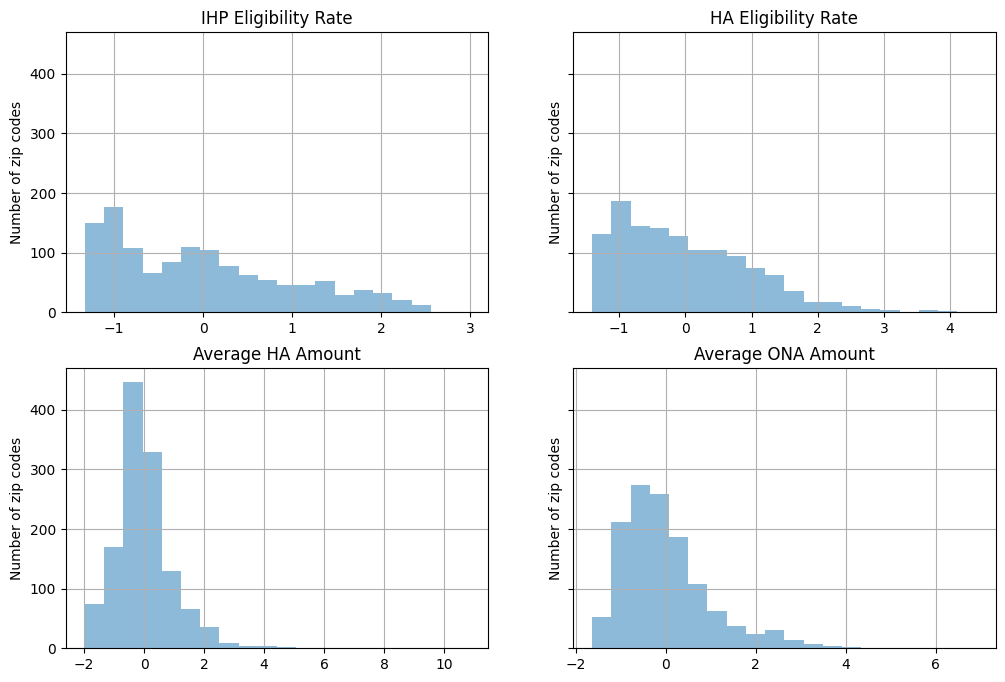

In [129]:
df_train = df[features].copy()
df_train = StandardScaler().fit_transform(df_train)
df_train = pd.DataFrame(df_train, columns=col)
fig,ax = plt.subplots(2,2,figsize=(12,8),sharey=True,squeeze=True)
for i, axi in enumerate(ax.flatten()):
    df_train[col[i]].hist(bins=20, alpha = 0.5, ax=axi)
    axi.set(title=variable_def[i],ylabel='Number of zip codes')
plt.show()


***Removing outliers***

Based on the distribution of data after standardizing the features, remove outliers that are outside of four times the standard deviations which may significantly impact the clustering results.

In [130]:
rows_to_drop = df_train[(np.abs(df_train)>4).any(axis=1)].index
df_train.drop(rows_to_drop, inplace=True)
df.drop(rows_to_drop,axis=0,inplace=True)
print(df.shape,df_train.shape)

(1261, 7) (1261, 4)


***Correlation analysis:***

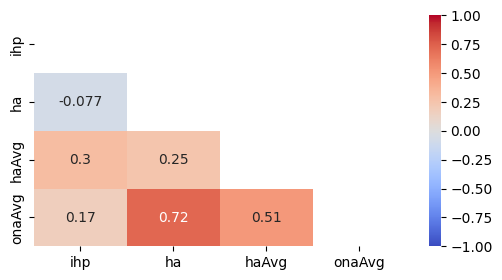

In [131]:
plt.figure(figsize=(6, 3))
corr_mat = df_train.corr()
sns.heatmap(corr_mat, mask=np.triu(corr_mat), vmin=-1, vmax=1, annot=True, fmt='.2g', cmap='coolwarm')
plt.show()

Multicollinearity or collinearity can potentially distort distance calculation in clustering analysis which tends to give more weight to correlated variables and skew the results. However, given that
> 1. low or moderate correlation observed among the features;
> 2. the features are derived in a way that is mutually independent; and
> 3. no assumption or requirement of equal weight and more weights on correlated variables are acceptable <br>

the collinearity problem is deemed a negligible in this study.

### 3. Clustering Analysis
#### 3.1 Selecting the best number of clusters with KMeans clusters using WCSS and Silhouette Score
First, take a look at the pairwise scatterplots of the features, which suggests most observations are densely distributed and no well-separated clusters are apparent. Given such characteristic and the low dimensionality of the dataset, the number of clusters generated should be relatively small (e.g., no more than 5) so that it's practical for interpretation.

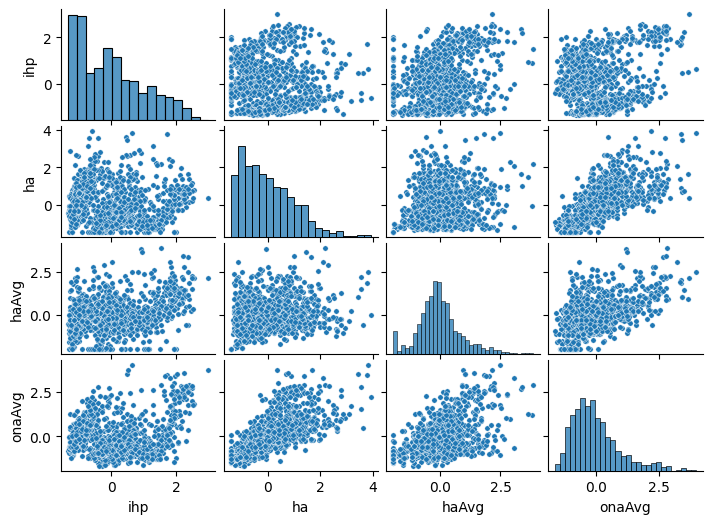

In [287]:
g = sns.pairplot(df_train,  plot_kws={"s": 15}) 
g.fig.set_size_inches(7, 5) 
plt.show()

***Finding the best number of clusters (k)***
1. Elbow Method in K-Means Clustering
> The Elbow Method helps find the optimal k value by plotting the the **Within-Cluster Sum of Squares (WCSS)** against a range of k values. The optimal number of clusters is found at the "elbow" point where the rate of decrease in WCSS sharply changes, indicating that further dividing the samples results doesn't result in significantly increased similararity within clusters. 

2. The silhouette plot and silhouette score
> The silhouette plot of **silhouette coefficients** shows how well samples are clustered with samples that are similar to themselves. Silhouette coefficient has a range of [-1, 1] where near 1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates the sample is located near or within the decision boundary of neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.
> 
> The **silhouette score** is the mean silhouette coefficient over all samples. Similarly, the best value is 1 which indicates dense and well separated clusters, and the worst value is -1 indicating that a sample has been assigned to the wrong cluster. Values near 0 indicate overlapping clusters. 


In [293]:
# Custom functions to plot WCSS and silhouette score

from sklearn.metrics import silhouette_samples, silhouette_score
def plot_wcss_sil_score(wcss, sil_score,title_str):
    fig,ax1 = plt.subplots(figsize=(6,3))
    ax1.plot(range(2,11),wcss, 'ro-',label='WCSS')
    ax1.set_ylabel('WCSS',color='r')
    ax1.set_xlabel('Number of clusters')
    ax1.legend(loc='lower left')
    ax2=ax1.twinx()
    ax2.plot(range(2,11),sil_score, 'bo-',label='Silhouette Score')
    ax2.set_ylabel('Silhouette Score',color='b')
    ax2.set_ylim((-1,1))
    ax2.legend(loc='upper right')
    plt.title(title_str)
    plt.grid(color='lightgray')
    plt.show()

import matplotlib.cm as cm
def plot_sil_score(X, cluster_labels_all):
    '''
    This code is adapted from 
    https://scikit-learn.org/1.6/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
    '''
    fig,ax = plt.subplots(3,3,figsize=(12,10))
    for i, axi in enumerate(ax.flatten()):
        n_clusters = i + 2
        cluster_labels = cluster_labels_all[i]

        axi.set_xlim([-0.1, 1])
        axi.set_ylim([0, len(X) + (n_clusters + 1) * 10])
        silhouette_avg = silhouette_score(X, cluster_labels)
    
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
    
            color = cm.nipy_spectral(float(i) / n_clusters)
            axi.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7
            )
    
            # Label the silhouette plots with their cluster numbers at the middle
            axi.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))    
            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
    
        axi.text(0.65, y_upper * 0.90, f"n_cluster: {n_clusters}")
        axi.set_xlabel("Silhouette Coefficient")
        axi.set_ylabel("Cluster label")
    
        # The vertical line for average silhouette score of all the values
        axi.axvline(x=silhouette_avg, color="red", linestyle="--")    
        axi.set_yticks([])  # Clear the yaxis labels / ticks
        axi.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
   
    plt.show()

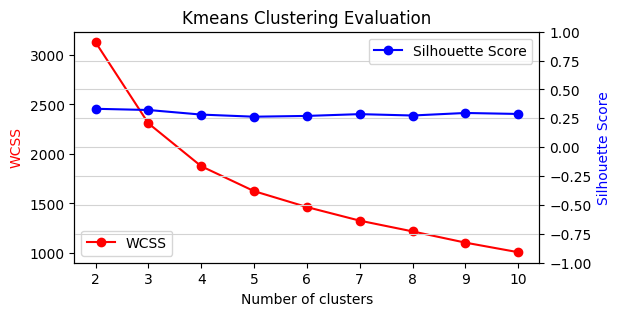

In [294]:
wcss = [] 
sil_score = []
cluster_labels_all_kmean = []
for i in range(2, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++',n_init=20, max_iter=500, random_state = 99)
    kmeans.fit(df_train) 
    wcss.append(kmeans.inertia_)

    labels = kmeans.predict(df_train)
    cluster_labels_all_kmean.append(labels)
    sil_score.append(silhouette_score(df_train, labels))

plot_wcss_sil_score(wcss, sil_score,'Kmeans Clustering Evaluation')

The plot above shows no clear "elbow" point and a stable, relatively low silhouette score (~0.32) when k ranges from 2 to 10, suggesting the lack of well-defined clusters in the sample, which is expected based the previous pairplot. 

**The less-than-ideal "optimal" k is probably at 3 where the rate of decrease in WCSS becomes much slower afterwards and the silhouette score is relatively high.**

Next check out the silhouette coefficients (plotted below). It shows that 
- lower values of k tend to result in uneven sized clusters;
- no k value is free from mis-assigned observations (i.e., negative silhouette values); and
- all resulting clusters regardless of k are partially above the average silhouette score.

 Overall, the silhouette plot indicates no clearly poor-performaing k value to exclude, while the better k values are not obvious either. Although k of 6, 7 or 8 seems to have relatively even sized clusters, we still prefer a smaller k value due to interpretability. **Therefore, the optimal number of clusters is determined to be three.**


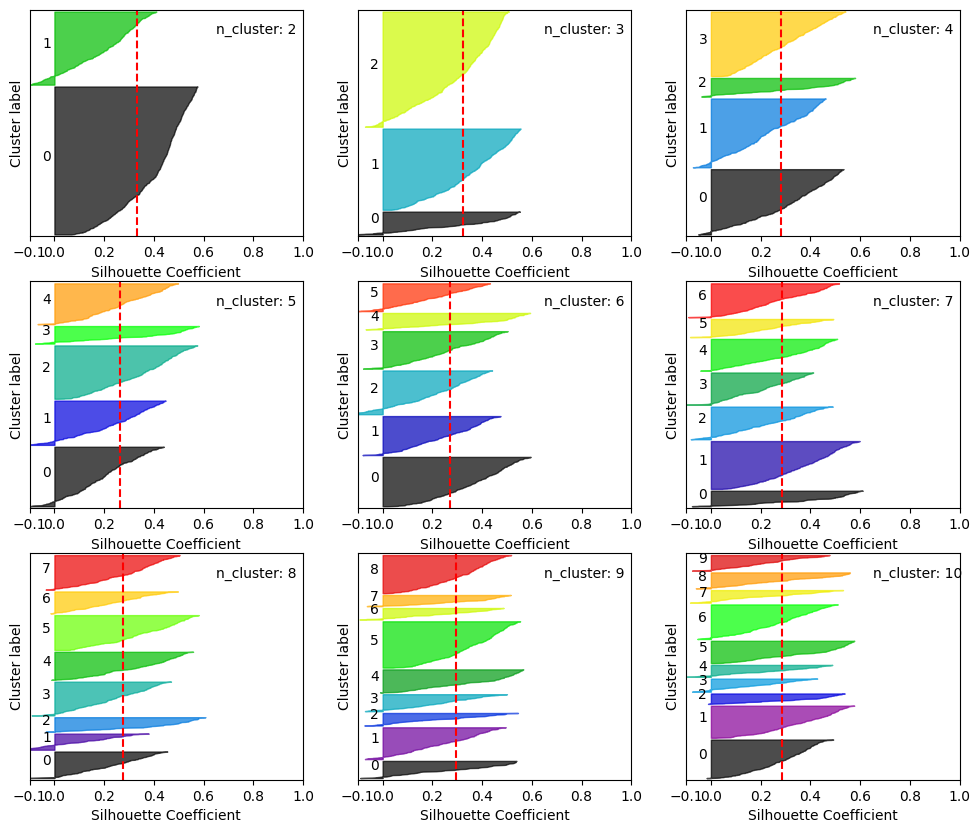

In [290]:
plot_sil_score(df_train,cluster_labels_all_kmean)

#### 3.2 Perform hyperparameter tuning on clustering algorithms

The **Silhouette Score** is used as the metric to evaluate the clustering quality of different hyperparameter settings. Howevever, it also has its limitations, which tends to favor uneven clusters due to its reliance on average intra-cluster distances and inter-cluster separation. Therefore, it's helpful to use the Silhouette Score in conjunction with other clustering evaluation metrics and domain knowledge to determine the practical clustering solution.

***Hyperparameter tuning for KMeans***

In [353]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'n_clusters': [3],
    'init': ['k-means++','random'],
    'n_init': [10, 20, 30],
    'max_iter': [300,400,500],
    'tol': [1e-4, 1e-3]
}
best_score = -1
best_params = None
best_kmeans_label = None
for params in ParameterGrid(param_grid):
    kmean = KMeans(**params)
    labels = kmean.fit_predict(df_train)

    score = silhouette_score(df_train, labels)
    cluster_sizes = np.bincount(labels)
    print(params,score,cluster_sizes)
    
    if score > best_score:
        best_score = score
        best_params = params
        best_kmeans_label = labels

print(f'Best KMeans parameters: {best_params}')
print(f'Best KMeans silhouette score: {best_score}')
    

{'init': 'k-means++', 'max_iter': 300, 'n_clusters': 3, 'n_init': 10, 'tol': 0.0001} 0.3226757882702972 [467 663 131]
{'init': 'k-means++', 'max_iter': 300, 'n_clusters': 3, 'n_init': 10, 'tol': 0.001} 0.32179489522272386 [662 466 133]
{'init': 'k-means++', 'max_iter': 300, 'n_clusters': 3, 'n_init': 20, 'tol': 0.0001} 0.32174802226691995 [663 131 467]
{'init': 'k-means++', 'max_iter': 300, 'n_clusters': 3, 'n_init': 20, 'tol': 0.001} 0.32223334357600547 [661 468 132]
{'init': 'k-means++', 'max_iter': 300, 'n_clusters': 3, 'n_init': 30, 'tol': 0.0001} 0.32220413637773815 [468 663 130]
{'init': 'k-means++', 'max_iter': 300, 'n_clusters': 3, 'n_init': 30, 'tol': 0.001} 0.32226018922029137 [132 662 467]
{'init': 'k-means++', 'max_iter': 400, 'n_clusters': 3, 'n_init': 10, 'tol': 0.0001} 0.3226757882702972 [663 467 131]
{'init': 'k-means++', 'max_iter': 400, 'n_clusters': 3, 'n_init': 10, 'tol': 0.001} 0.321919921296421 [627 502 132]
{'init': 'k-means++', 'max_iter': 400, 'n_clusters': 3, 

Results above show the KMeans algorithm generally generate reasonably even clusters. Although the smallest cluster is usually around 10% of the sample size, it is deems acceptable in our study. **Therefore the best parameters obtained are accepted as the solution of KMeans clustering.** The clusters are visualized below.

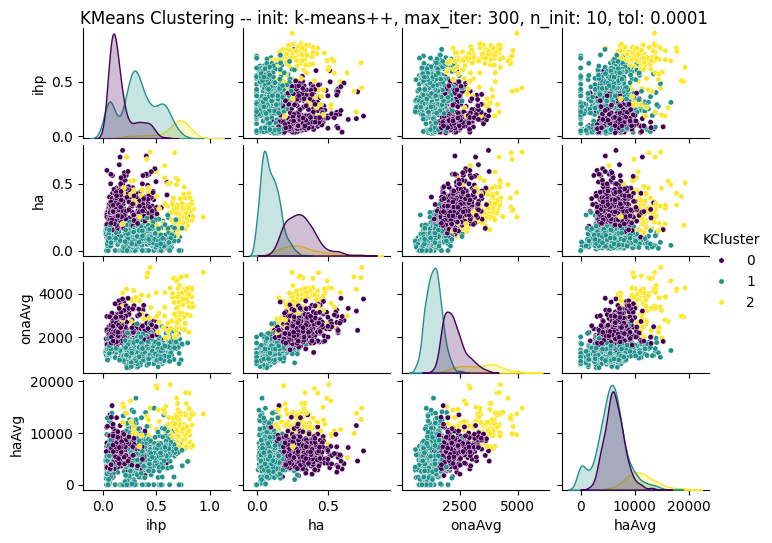

In [372]:
df['KCluster'] = best_kmeans_label
g= sns.pairplot(df[['ihp','ha','onaAvg','haAvg','KCluster']], hue='KCluster',palette='viridis',  plot_kws={"s": 15}) 
g.fig.set_size_inches(7.5, 5) 
plt.suptitle("KMeans Clustering -- init: k-means++, max_iter: 300, n_init: 10, tol: 0.0001",y=1.02)
plt.show()

***Hyperparameter tuning for AgglomerativeClustering***

In [352]:
param_grid = {
    'n_clusters': [3],
    'linkage': ['ward','complete','average','single'],
    'affinity': ['euclidean', 'manhattan', 'cosine']
}
best_score = -1
best_params = None
best_aglm_label = None
for params in ParameterGrid(param_grid):
    if params['linkage']=='ward' and params['affinity'] != 'euclidean':
        continue
        
    aglm = AgglomerativeClustering(**params)
    labels = aglm.fit_predict(df_train)

    score = silhouette_score(df_train, labels)
    cluster_sizes = np.bincount(labels)

    print(params,score,cluster_sizes)
    if score > best_score:
        best_score = score
        best_params = params
        best_aglm_label = labels

print(f'Best AgglomerativeClustering parameters: {best_params}')
print(f'Best AgglomerativeClustering silhouette score: {best_score}')

{'affinity': 'euclidean', 'linkage': 'ward', 'n_clusters': 3} 0.2905774447737911 [849 321  91]
{'affinity': 'euclidean', 'linkage': 'complete', 'n_clusters': 3} 0.31402194243416437 [  80 1089   92]
{'affinity': 'euclidean', 'linkage': 'average', 'n_clusters': 3} 0.38725393830525795 [ 144    4 1113]
{'affinity': 'euclidean', 'linkage': 'single', 'n_clusters': 3} 0.41302899827212686 [1259    1    1]
{'affinity': 'manhattan', 'linkage': 'complete', 'n_clusters': 3} 0.24578580438501482 [176 767 318]
{'affinity': 'manhattan', 'linkage': 'average', 'n_clusters': 3} 0.456268312700625 [  84 1175    2]
{'affinity': 'manhattan', 'linkage': 'single', 'n_clusters': 3} 0.4331729993816002 [   2    2 1257]
{'affinity': 'cosine', 'linkage': 'complete', 'n_clusters': 3} 0.24016730316917206 [644 349 268]
{'affinity': 'cosine', 'linkage': 'average', 'n_clusters': 3} 0.2826611561285074 [587 486 188]
{'affinity': 'cosine', 'linkage': 'single', 'n_clusters': 3} -0.2724492698333147 [1259    1    1]
Best Aggl

The "best" AgglomerativeClustering result has a much higher silhouette score than the KMeans algorithm, but the higher silhouette scores are all associated with severely uneven clusters, i.e., the smallest clusters often have less than 5 members. To have a reasonable size of cluster for studying the IHP characteristics, we will further investigate the following hyperparameter settings that produced reasonable cluster sizes:
> 'affinity': 'euclidean', 'linkage': 'ward'<br>
> 'affinity': 'euclidean', 'linkage': 'complete'<br>
> 'affinity': 'cosine', 'linkage': 'average'<br>

The clustering results of the three settings are re-generated and visualized below.

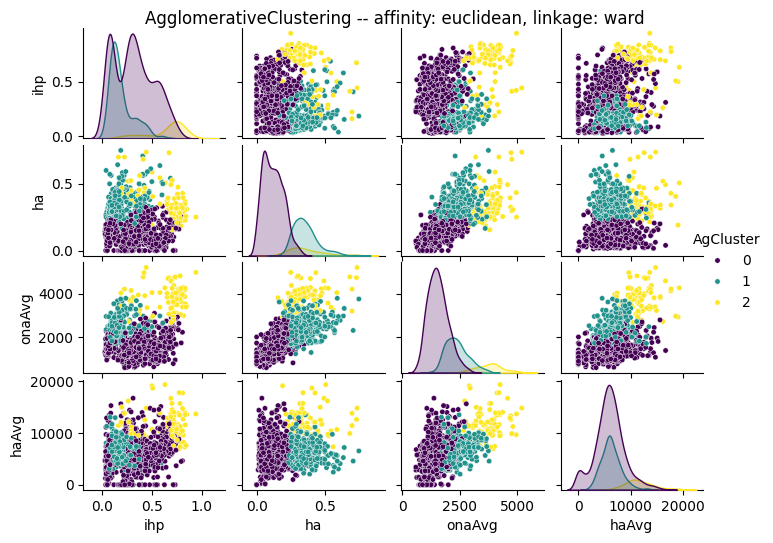

In [370]:
# ‘affinity’: ‘euclidean’, ‘linkage’: ‘ward’
aglm = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
labels = aglm.fit_predict(df_train)
df['AgCluster'] = labels

g= sns.pairplot(df[['ihp','ha','onaAvg','haAvg','AgCluster']], hue='AgCluster',palette='viridis',  plot_kws={"s": 15}) 
g.fig.set_size_inches(7.5, 5) 
plt.suptitle("AgglomerativeClustering -- affinity: euclidean, linkage: ward",y=1.02)

plt.show()

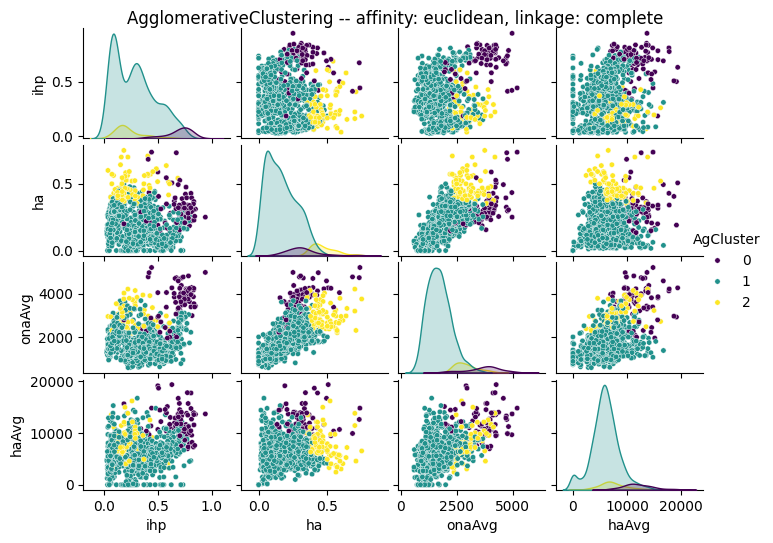

In [369]:
# ‘affinity’: ‘euclidean’, ‘linkage’: ‘complete’
aglm = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
labels = aglm.fit_predict(df_train)
df['AgCluster'] = labels

g= sns.pairplot(df[['ihp','ha','onaAvg','haAvg','AgCluster']], hue='AgCluster',palette='viridis',  plot_kws={"s": 15}) 
g.fig.set_size_inches(7.5, 5) 
plt.suptitle("AgglomerativeClustering -- affinity: euclidean, linkage: complete",y=1.02)
plt.show()

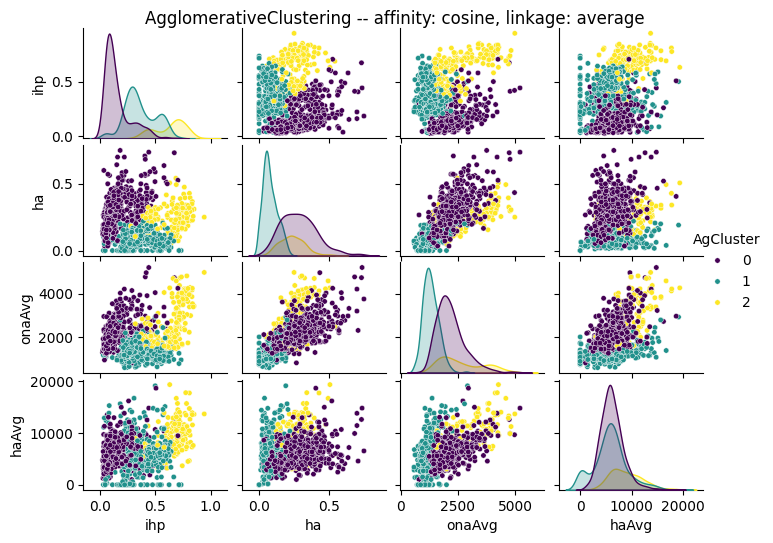

In [373]:
# ‘affinity’: ‘cosine’, ‘linkage’: ‘average’
aglm = AgglomerativeClustering(n_clusters=3, affinity='cosine', linkage='average')
labels = aglm.fit_predict(df_train)
df['AgCluster'] = labels

g=sns.pairplot(df[['ihp','ha','onaAvg','haAvg','AgCluster']], hue='AgCluster',palette='viridis',  plot_kws={"s": 15}) 
g.fig.set_size_inches(7.5, 5) 
plt.suptitle("AgglomerativeClustering -- affinity: cosine, linkage: average",y=1.02)
plt.show()

Of the three hyperparameter settings for AgglomerativeClustering, the second and third settings resulted in more overlapping of clusters than the first one which make interpretation of the cluster-wise IHP characteristics difficult. Therefore, **the hyperparameters of {'affinity': 'euclidean', 'linkage': 'ward'} are chosen as the AgglomerativeClustering solution.**

***Adding final AgglomerativeClustering solution to data table:***

In [375]:
aglm = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
labels = aglm.fit_predict(df_train)
df['AgCluster'] = labels

***Switching the cluster labels of KMeans solution to match with the clusters from AgglomerativeClustering:***

In [394]:
df['KCluster'] = df['KCluster'].replace({0:1, 1:0})

***Visualizing the clusters from the two algorithms***

In [452]:
def scatter_plot(data, x, y, hue, axs):
    sns.scatterplot(data=data,x=x,y=y,hue=hue,palette='viridis',ax=axs,s=12,legend=False) 
    # Remove tick labels
    axs.set_xticks([])
    axs.set_yticks([])
    axs.set_xticklabels([])
    axs.set_yticklabels([])

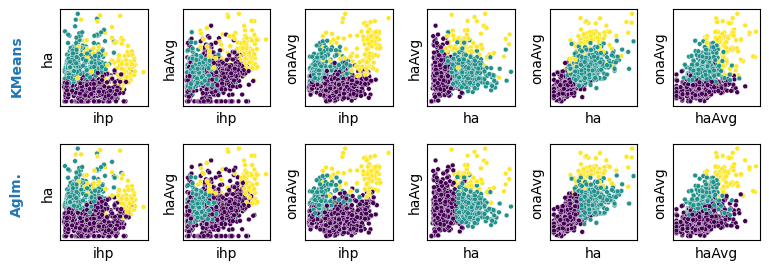

In [453]:
fig, ax = plt.subplots(2,6,figsize=(10,3))
fig.subplots_adjust(left=0.2, wspace=0.4,hspace=0.4)
scatter_plot(data=df,x='ihp',y='ha',hue='KCluster',axs=ax[0][0])
scatter_plot(data=df,x='ihp',y='ha',hue='AgCluster',axs=ax[1][0])
scatter_plot(data=df,x='ihp',y='haAvg',hue='KCluster',axs=ax[0][1])
scatter_plot(data=df,x='ihp',y='haAvg',hue='AgCluster',axs=ax[1][1])
scatter_plot(data=df,x='ihp',y='onaAvg',hue='KCluster',axs=ax[0][2])
scatter_plot(data=df,x='ihp',y='onaAvg',hue='AgCluster',axs=ax[1][2])
scatter_plot(data=df,x='ha',y='haAvg',hue='KCluster',axs=ax[0][3])
scatter_plot(data=df,x='ha',y='haAvg',hue='AgCluster',axs=ax[1][3])
scatter_plot(data=df,x='ha',y='onaAvg',hue='KCluster',axs=ax[0][4])
scatter_plot(data=df,x='ha',y='onaAvg',hue='AgCluster',axs=ax[1][4])
scatter_plot(data=df,x='haAvg',y='onaAvg',hue='KCluster',axs=ax[0][5])
scatter_plot(data=df,x='haAvg',y='onaAvg',hue='AgCluster',axs=ax[1][5])
fig.text(0.15,0.6,'KMeans',rotation='vertical',color='tab:blue',fontweight='bold')
fig.text(0.15,0.2,'Aglm.',rotation='vertical',color='tab:blue',fontweight='bold')
plt.show()

### 4. Summary
- In this study, clustering analysis was performed on FEMA's RegistrationIntakeIndividualsHouseholdPrograms dataset using the KMeans and AglomerativeClustering algorithms from scikit-learn.
- The densely distributed observations posed a challenge to determine the best number of clusters. Eventually, the number of clusters were determined from Within-Cluster-Sum-of-Squares in conjunction with Silhouette Score and domain knowledge.
- During hyperparameter tuning where Silhouette Score is used as a performance metric, it is observed that KMeans is relatively insensitive to the hyperparameters and less likely to produce severely uneven sized clusters. In contrast, AglomerativeClustering is highly sensitive to the linkage and affinity parameters and more likely to produce severely uneven sized clusters.
- Inflation of the Silhouette Score for AglomerativeClustering is observed where high scores are associated with uneven clusters. To ensure meaningful analysis of the clusters, the best AglomerativeClustering model parameters were chosen by applying domain knowledge instead of Silhouette Score.
- The final solutions of both KMeans and AglomerativeClustering algorithms exhibit similar clustering distributions, while KMeans allows for greater amount of overlapping among clusters than AglomerativeClustering.



***Loading the Census Gazettear data containing the geographic coordinates of zip codes and merging with the clustering labels***

In [395]:
gaz = pd.read_csv('2024_Gaz_zcta_national.txt', sep='\t')
gaz.rename(columns={gaz.columns[-1]: 'INTPTLONG'}, inplace=True)
gaz = pd.merge(gaz, df[['disasterNumber','zipCode','KCluster','AgCluster']], left_on='GEOID', right_on='zipCode', how='right')
gaz[['KCluster','AgCluster']] = gaz[['KCluster','AgCluster']].astype(str)
gaz.head(2)

,GEOID,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,disasterNumber,zipCode,KCluster,AgCluster
0,32301,26426962,213500,10.204,0.082,30.427618,-84.257753,4794,32301,0,0
1,32303,90198141,10567097,34.826,4.080,30.512386,-84.344877,4794,32303,0,0


***Loading geopandas library and basemap for county boundaries***

In [ ]:
import geopandas as gpd
shapefile = r"C:\\Users\fchen2\\Documents\\Projects\\Projection\\Census Data\\cb_2023_us_all_500k\\cb_2023_us_county_500k\\cb_2023_us_county_500k.shp"

county_basemap = gpd.read_file(shapefile)
county_basemap = county_basemap[county_basemap.STUSPS=='FL']

***Custom function for mapping clusters***

In [402]:
def map_clusters(gdf, basemap, labels, title):
    gdf_map = gdf.copy()
    gdf_map['cluster'] = labels
    labels = labels.astype(int)
    # labels = labels + (1-np.min(labels)) # convert labels to begin from 1
    #.astype(str)

    dr = gdf_map.disasterNumber.unique()
    fig, ax = plt.subplots(1, 4, figsize=(15, 5),tight_layout=True)
    ccmap=['indigo','teal','yellow'] #,'tab:blue'
    labs = np.unique(labels)
    legend_bool = True
    for i in range(4):
        basemap.plot(color='lightgray', edgecolor='white',ax=ax[i])
        gdf_i =  gdf_map[gdf_map.disasterNumber==dr[i]]
        # print(dr[i],len(gdf_i))
        if len(gdf_i.cluster.unique())==3:
            gdf_i.plot(column='cluster', legend=legend_bool, cmap='viridis',alpha=0.85,marker='o', markersize=15, ax=ax[i],label=gdf_i.cluster)
            legend_bool = False
        else:        
            for ii in labs:
                gdf_i[gdf_i.cluster==str(ii)].plot(color=ccmap[ii],alpha=0.85,marker='o', markersize=15, ax=ax[i])
        minx,maxx,miny,maxy = gdf_map.INTPTLONG.min(), gdf_map.INTPTLONG.max(), gdf_map.INTPTLAT.min(), gdf_map.INTPTLAT.max()
        ax[i].set(xlim=(minx-0.1,maxx+0.1),ylim=(miny-0.1,maxy+0.1),title='DR'+str(dr[i]))
        ax[i].set_axis_off()
    plt.suptitle(title, fontsize=18)
    plt.show()

***Creating a GeoDataFrame that represents the observations as point features for mapping***

In [397]:
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(gaz['INTPTLONG'], gaz['INTPTLAT'])]
gdf_zip = gpd.GeoDataFrame(gaz, geometry=geometry)
gdf_zip.columns

Index(['GEOID', 'ALAND', 'AWATER', 'ALAND_SQMI', 'AWATER_SQMI', 'INTPTLAT',
       'INTPTLONG', 'disasterNumber', 'zipCode', 'KCluster', 'AgCluster',
       'geometry'],
      dtype='object')

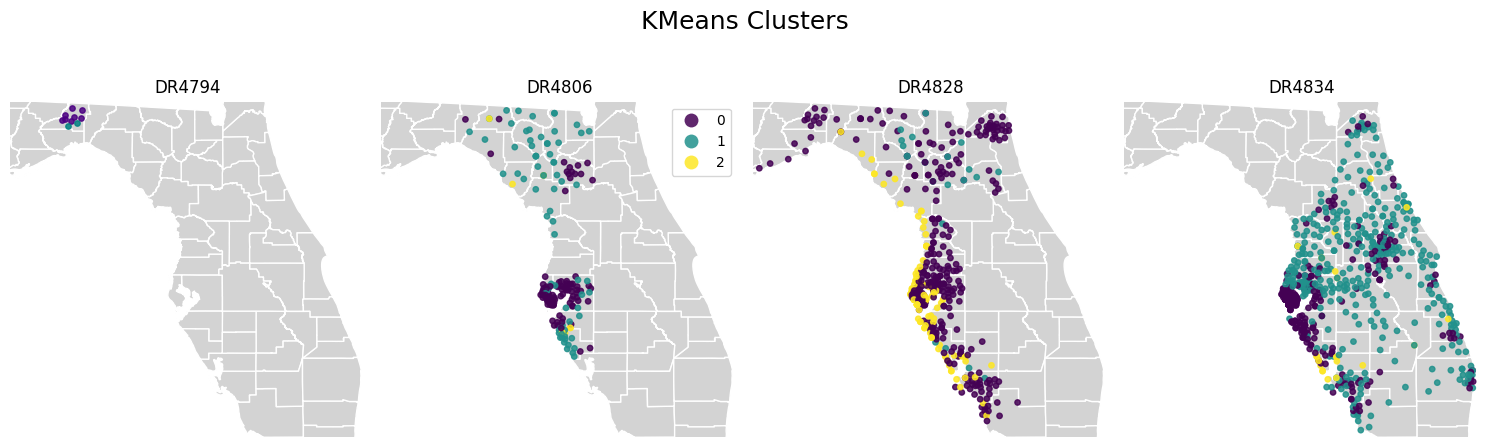

In [403]:
map_clusters(gdf_zip,county_basemap,gdf_zip.KCluster,'KMeans Clusters')       

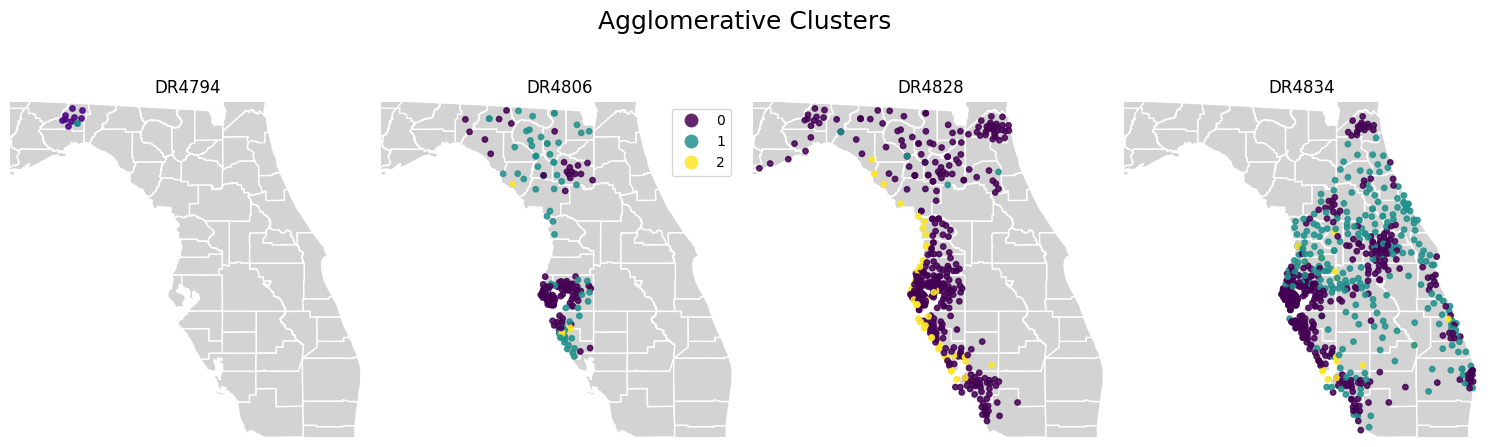

In [404]:
map_clusters(gdf_zip,county_basemap,gdf_zip.AgCluster,'Agglomerative Clusters')  

In [390]:
from IPython.display import Image

# URL of the image
url = "https://example.com/path/to/your/image.jpg"

# Display the image
Image(url=url)


,GEOID,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,disasterNumber,zipCode,KCluster,AgCluster,geometry
0,32301,26426962,213500,10.204,0.082,30.427618,-84.257753,4794,32301,1,0,POINT (-84.25775 30.42762)
1,32303,90198141,10567097,34.826,4.080,30.512386,-84.344877,4794,32303,1,0,POINT (-84.34488 30.51239)
2,32304,39304855,464397,15.176,0.179,30.451991,-84.352792,4794,32304,1,0,POINT (-84.35279 30.45199)
3,32305,248520998,2759069,95.954,1.065,30.349872,-84.300765,4794,32305,0,0,POINT (-84.30076 30.34987)
4,32308,40939447,589073,15.807,0.227,30.480911,-84.219746,4794,32308,1,0,POINT (-84.21975 30.48091)
5,32309,315989985,9475297,122.004,3.658,30.581250,-84.104073,4794,32309,1,0,POINT (-84.10407 30.58125)
6,32310,238003388,12146809,91.894,4.690,30.433038,-84.391845,4794,32310,1,0,POINT (-84.39185 30.43304)
7,32311,146337258,3283244,56.501,1.268,30.390050,-84.181035,4794,32311,0,1,POINT (-84.18103 30.39005)
8,32312,241910026,43512323,93.402,16.800,30.604278,-84.243286,4794,32312,1,0,POINT (-84.24329 30.60428)
9,32317,92075940,2644766,35.551,1.021,30.470481,-84.116694,4794,32317,1,0,POINT (-84.11669 30.47048)


'c://users//fchen2//documents//projects//projection//census data//cb_2018_us_county_500k//cb_2023_us_county_500k.shp'